In [2]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [3]:
# data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')
data = pd.read_csv('Data/sp500_full_19991201_to_20231231.csv')
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

# Generate for all pairs

In [4]:
tickers = list(set(data.Ticker.values))
combinations = list(itertools.combinations(tickers, 2))
len(combinations)
batches = list(chunker(combinations, 1000))

In [5]:
len(data)

2169122

In [10]:
from importlib import reload
import pair_trading_foundations.data_generation
reload(pair_trading_foundations.data_generation)
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = 1
    features_tb, labels_tb = generate_training_data(
        data=data,
        moving_average=1,
        training_len=300,
        test_len=1,
        entry_signal=2,
        exit_signal=0.2,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'Data/Training/pair_features_{i+1}_pairs{max_pairs}_300_120.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
    break
    
len(combined)
combined

Getting 1th out of 64 batches
1000 stock pairs detected
Took 0.8080072402954102 to initilize. Entering ticker pair loop
Max combination = 1
Took 4.34623908996582 to finish
Took 4.439852952957153 seconds


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,AMAT,2001-02-09 00:00:00,22.531250,21.000000,32504200.0,15.688189,BLK,43.000000,42.200001,27200.0,26.387505,10.699316,12.463475,5.885492,10.699316,NaN,0.0,10.937347,0.0
1,AMAT,2001-02-12 00:00:00,22.500000,21.101562,28449600.0,16.194258,BLK,43.709999,42.000000,33100.0,27.131605,10.937347,12.472297,5.881199,10.937347,NaN,0.0,12.080793,0.0
2,AMAT,2001-02-13 00:00:00,22.500000,20.500000,42626000.0,15.182117,BLK,43.990002,43.139999,33900.0,27.262911,12.080793,12.480744,5.878802,12.080793,NaN,0.0,9.720858,0.0
3,AMAT,2001-02-14 00:00:00,23.843750,21.000000,95765800.0,17.229399,BLK,43.459999,42.500000,20800.0,26.950256,9.720858,12.483725,5.877169,9.720858,NaN,0.0,8.942307,0.0
4,AMAT,2001-02-15 00:00:00,25.312500,23.718750,55611800.0,18.195541,BLK,43.500000,42.700001,18400.0,27.137848,8.942307,12.481013,5.878620,8.942307,NaN,0.0,8.572243,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5752,AMAT,2023-12-21 00:00:00,161.820007,159.580002,4257300.0,161.116943,BLK,799.369995,791.659973,341100.0,799.099976,637.983032,551.309773,42.441537,637.983032,NaN,0.0,640.644150,0.0
5753,AMAT,2023-12-22 00:00:00,163.000000,160.839996,2770600.0,161.775833,BLK,807.520020,800.150024,426300.0,802.419983,640.644150,551.885140,42.478813,640.644150,NaN,0.0,642.607925,0.0
5754,AMAT,2023-12-26 00:00:00,164.970001,162.100006,2520500.0,164.002060,BLK,809.099976,803.440002,280600.0,806.609985,642.607925,552.500446,42.451469,642.607925,NaN,0.0,649.317810,0.0
5755,AMAT,2023-12-27 00:00:00,164.990005,163.529999,3319600.0,163.932190,BLK,813.250000,808.630005,298000.0,813.250000,649.317810,553.077886,42.586541,649.317810,NaN,0.0,651.565964,0.0


count    5757.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pnls, dtype: float64

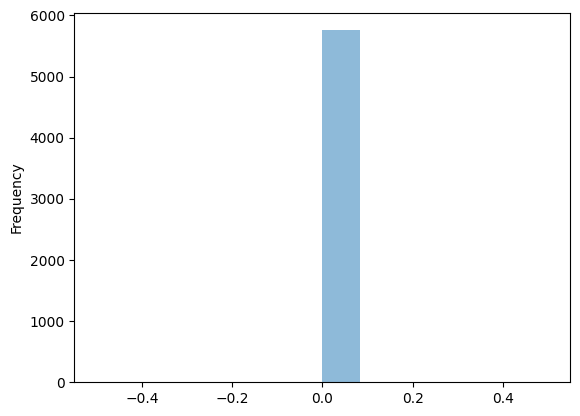

In [11]:
labels_tb
labels_tb = labels_tb.dropna()
labels_tb.pnls.plot.hist(bins=12, alpha=0.5)
labels_tb.pnls.describe()